# Getting started

Once you've chosen your scenario, download the data from [the Iowa website](https://data.iowa.gov/Economy/Iowa-Liquor-Sales/m3tr-qhgy) in csv format. Start by loading the data with pandas. You may need to parse the date columns appropriately.

#### Scenario 2: Market research for new store locations

A liquor store owner in Iowa is looking to expand to new locations and has hired you to investigate the market data for potential new locations. The business owner is interested in the details of the best model you can fit to the data so that his team can evaluate potential locations for a new storefront.

**Goal for Scenario #2:** Your task is to:

* Build models of total sales based on location, price per bottle, total bottles sold. You may find it useful to build models for each county, zip code, or city.
* Provide a table of the best performing stores by location type of your choice (city, county, or zip code) and the predictions of your model(s).
* Based on your models and the table of data, recommend some general locations to the business owner, taking into account model performance. Validate your model's performance and ability to predict future sales using cross-validation.
* _Bonus_: Recommend targets for volume sold and price per bottle!

---

In [688]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pprint

from IPython.display import Image
from sklearn import linear_model

plt.style.use('fivethirtyeight')

In [214]:
## Load the data into a DataFrame
df = pd.read_csv("Iowa_Liquor_sales_sample_10pct.csv")

## Transform the dates if needed, e.g.
# df["Date"] = pd.to_datetime(df["Date"], format="%m-%d-%y")

df.head()

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
0,11/04/2015,3717,SUMNER,50674,9.0,Bremer,1051100.0,APRICOT BRANDIES,55,54436,Mr. Boston Apricot Brandy,750,$4.50,$6.75,12,$81.00,9.0,2.38
1,03/02/2016,2614,DAVENPORT,52807,82.0,Scott,1011100.0,BLENDED WHISKIES,395,27605,Tin Cup,750,$13.75,$20.63,2,$41.26,1.5,0.40
2,02/11/2016,2106,CEDAR FALLS,50613,7.0,Black Hawk,1011200.0,STRAIGHT BOURBON WHISKIES,65,19067,Jim Beam,1000,$12.59,$18.89,24,$453.36,24.0,6.34
3,02/03/2016,2501,AMES,50010,85.0,Story,1071100.0,AMERICAN COCKTAILS,395,59154,1800 Ultimate Margarita,1750,$9.50,$14.25,6,$85.50,10.5,2.77
4,08/18/2015,3654,BELMOND,50421,99.0,Wright,1031080.0,VODKA 80 PROOF,297,35918,Five O'clock Vodka,1750,$7.20,$10.80,12,$129.60,21.0,5.55


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270955 entries, 0 to 270954
Data columns (total 18 columns):
Date                     270955 non-null object
Store Number             270955 non-null int64
City                     270955 non-null object
Zip Code                 270955 non-null object
County Number            269878 non-null float64
County                   269878 non-null object
Category                 270887 non-null float64
Category Name            270323 non-null object
Vendor Number            270955 non-null int64
Item Number              270955 non-null int64
Item Description         270955 non-null object
Bottle Volume (ml)       270955 non-null int64
State Bottle Cost        270955 non-null object
State Bottle Retail      270955 non-null object
Bottles Sold             270955 non-null int64
Sale (Dollars)           270955 non-null object
Volume Sold (Liters)     270955 non-null float64
Volume Sold (Gallons)    270955 non-null float64
dtypes: float64(4), int64(

### Data Munging

In [294]:
df['Date'] = df['Date'].apply(pd.to_datetime)

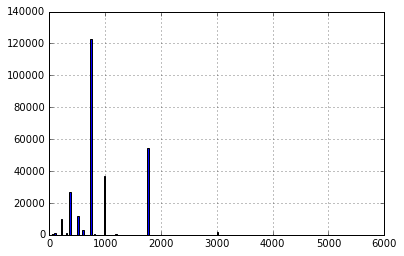

In [169]:
df['Bottle Volume (ml)'].hist(bins = 200)

Most common bottle type is 750ml. 1750ml is second most popular.

In [217]:
# Function to convert money columns from string to float

def conv_money(x):
    x = x.split('.')
    return (float(x[0][1:]) + (float(x[1]) / 100))

In [218]:
# Converting columns with money value to float

df[['State Bottle Cost', 'State Bottle Retail', "Sale (Dollars)"]] = \
df[['State Bottle Cost', 'State Bottle Retail', "Sale (Dollars)"]].applymap(conv_money)

In [219]:
df['Item Description'] = df['Item Description'].apply(lambda x: x.strip())

In [220]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270955 entries, 0 to 270954
Data columns (total 18 columns):
Date                     270955 non-null object
Store Number             270955 non-null int64
City                     270955 non-null object
Zip Code                 270955 non-null object
County Number            269878 non-null float64
County                   269878 non-null object
Category                 270887 non-null float64
Category Name            270323 non-null object
Vendor Number            270955 non-null int64
Item Number              270955 non-null int64
Item Description         270955 non-null object
Bottle Volume (ml)       270955 non-null int64
State Bottle Cost        270955 non-null float64
State Bottle Retail      270955 non-null float64
Bottles Sold             270955 non-null int64
Sale (Dollars)           270955 non-null float64
Volume Sold (Liters)     270955 non-null float64
Volume Sold (Gallons)    270955 non-null float64
dtypes: float64(7), int

## Cleaning Zipcodes

In [221]:
## Checking to see if all zipcodes have length of 5

df[df['Zip Code'].apply(lambda x: len(x) != 5)]

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)


In [222]:
# Since all has 5, change all to int types

df[df['Zip Code'].apply(lambda x: int(x))]

ValueError: invalid literal for int() with base 10: '712-2'

In [223]:
# Even all is length 5, 1 entry was '712-2'
# Googled this, turned out to be area code, change to 51529

df[df['Zip Code'].apply(lambda x: x == '712-2')]

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
114,01/16/2015,4307,DUNLAP,712-2,43.0,Harrison,1062300.0,FLAVORED RUM,35,43136,Bacardi Limon,750,8.50,12.75,2,25.50,1.50,0.40
2695,01/05/2015,4307,DUNLAP,712-2,43.0,Harrison,1012100.0,CANADIAN WHISKIES,115,11777,Black Velvet,1000,6.63,9.95,12,119.40,12.00,3.17
4129,10/19/2015,4307,DUNLAP,712-2,43.0,Harrison,1012100.0,CANADIAN WHISKIES,115,10553,Black Velvet Cinnamon Rush,750,6.75,10.13,3,30.39,2.25,0.59
5506,01/05/2015,4307,DUNLAP,712-2,43.0,Harrison,1081380.0,MISCELLANEOUS SCHNAPPS,65,82627,Dekuyper Cherry Pucker,1000,7.62,11.43,1,11.43,1.00,0.26
5512,11/20/2015,4307,DUNLAP,712-2,43.0,Harrison,1051140.0,PEACH BRANDIES,434,56206,Paramount Peach Flavored Brandy,750,5.48,8.22,1,8.22,0.75,0.20
8186,03/14/2016,4307,DUNLAP,712-2,NaN,NaN,1031080.0,VODKA 80 PROOF,55,35314,Barton Vodka,375,1.71,2.57,3,7.71,1.12,0.30
8642,11/02/2015,4307,DUNLAP,712-2,43.0,Harrison,1081400.0,TRIPLE SEC,434,86310,La Prima Triple Sec,1000,3.00,4.50,1,4.50,1.00,0.26
9347,03/21/2016,4307,DUNLAP,712-2,NaN,NaN,1081400.0,TRIPLE SEC,434,86310,La Prima Triple Sec,1000,3.00,4.50,3,13.50,3.00,0.79
16502,12/26/2015,4307,DUNLAP,712-2,43.0,Harrison,1031200.0,VODKA FLAVORED,380,41783,Uv Blue Raspberry Vodka Mini,500,4.89,7.34,1,7.34,0.50,0.13
16928,11/09/2015,4307,DUNLAP,712-2,43.0,Harrison,1062300.0,FLAVORED RUM,260,43287,Captain Morgan Parrot Bay Mango,750,7.49,11.24,1,11.24,0.75,0.20


In [224]:
# Changed erroneous zipcode

df.loc[df['Zip Code'] == '712-2', 'Zip Code'] = '51529'


In [225]:
# Changed zipcodes to int type

df['Zip Code'] = df['Zip Code'].apply(lambda x: int(x))

In [279]:
df[df['Zip Code'] == 56201].head()

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
1871,01/16/2015,4722,BURLINGTON,56201,29.0,Des Moines,1012100.0,CANADIAN WHISKIES,115,11788,Black Velvet,1750,10.45,15.68,6,94.08,10.5,2.77
10905,05/22/2015,4722,BURLINGTON,56201,29.0,Des Moines,1011200.0,STRAIGHT BOURBON WHISKIES,65,19476,Maker's Mark,750,16.79,25.19,12,302.28,9.0,2.38
16256,05/11/2015,4722,BURLINGTON,56201,29.0,Des Moines,1031080.0,VODKA 80 PROOF,301,38176,Titos Vodka,750,9.65,14.48,12,173.76,9.0,2.38
38808,09/21/2015,4722,BURLINGTON,56201,29.0,Des Moines,1031080.0,VODKA 80 PROOF,301,38176,Titos Vodka,750,9.65,14.48,12,173.76,9.0,2.38
67365,02/23/2015,4722,BURLINGTON,56201,29.0,Des Moines,1062300.0,FLAVORED RUM,370,42716,Malibu Coconut Rum,750,7.49,11.24,12,134.88,9.0,2.38


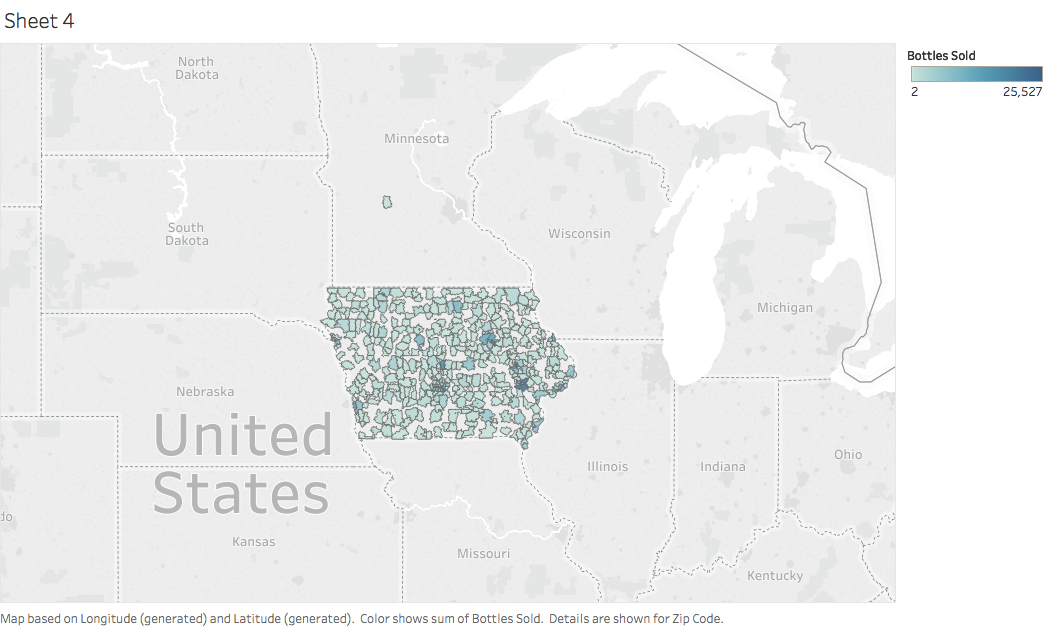

In [281]:
Image(filename='wrong_zip_des_moines.png')

In [280]:
# Correct Zip Code for Des Moines, Burlington

df.loc[df['Zip Code'] == 56201, 'Zip Code'] = 52601

## Cleaning City Values

In [226]:
list(df['City'].unique())

['SUMNER',
 'DAVENPORT',
 'CEDAR FALLS',
 'AMES',
 'BELMOND',
 'CEDAR RAPIDS',
 'OTTUMWA',
 'CLEAR LAKE',
 'BONDURANT',
 'SHELLSBURG',
 'WEST DES MOINES',
 'OSKALOOSA',
 'WEST POINT',
 'CORALVILLE',
 'WATERLOO',
 'NEWTON',
 'TOLEDO',
 'SIOUX CENTER',
 'MASON CITY',
 'MILFORD',
 'IOWA CITY',
 'COUNCIL BLUFFS',
 'GRIMES',
 'KEOKUK',
 'INDIANOLA',
 'FORT DODGE',
 'DES MOINES',
 'HUXLEY',
 'LA PORTE CITY',
 'MARION',
 'ANKENY',
 'DYSART',
 'EAGLE GROVE',
 'OGDEN',
 'MAQUOKETA',
 'CARROLL',
 'WEBSTER CITY',
 'SIOUX CITY',
 'WASHINGTON',
 'CHARLES CITY',
 'MANCHESTER',
 'SHELDON',
 'ALTOONA',
 'STORM LAKE',
 'GRUNDY CENTER',
 'SPIRIT LAKE',
 'DUBUQUE',
 'STUART',
 'SCHLESWIG',
 'MOUNT PLEASANT',
 'GUTHRIE CENTER',
 'FORT ATKINSON',
 'SPENCER',
 'MUSCATINE',
 'LENOX',
 'MISSOURI VALLEY',
 'IOWA FALLS',
 'ALGONA',
 'WAUKEE',
 'LECLAIRE',
 'LAMONI',
 'CLINTON',
 'PARKERSBURG',
 'BURLINGTON',
 'DUNLAP',
 'ORANGE CITY',
 'MANNING',
 'LOHRVILLE',
 'JOHNSTON',
 'OELWEIN',
 'MONTICELLO',
 'BRITT',
 

In [227]:
# There are some 'City' entries which are in lower case while the majority is in Upper Case. 
# To prevent double counting, all "City" entries are changed to upper case

df['City'] = df['City'].apply(lambda x: x.upper())

## Cleaning NaN County entries

In [228]:
# Create a new dataframe for rows with NaNs in any cells

df_nan = df[pd.isnull(df).any(axis = 1)]

In [229]:
df_nan.head()

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
135,01/20/2016,5222,CEDAR RAPIDS,52402,NaN,NaN,1051010.0,AMERICAN GRAPE BRANDIES,115,53214,Paul Masson Grande Amber Brandy,375,3.22,4.83,24,115.92,9.00,2.38
198,03/02/2016,3820,SIOUX CITY,51103,NaN,NaN,1032080.0,IMPORTED VODKA,35,34359,Grey Goose Vodka,200,5.00,7.50,12,90.00,2.40,0.63
272,03/21/2016,4222,EVANSDALE,50707,NaN,NaN,1062300.0,FLAVORED RUM,370,42716,Malibu Coconut Rum,750,7.49,11.24,3,33.72,2.25,0.59
290,03/21/2016,5236,ANAMOSA,52205,NaN,NaN,1081600.0,WHISKEY LIQUEUR,421,64868,Fireball Cinnamon Whiskey,1750,15.33,23.00,6,138.00,10.50,2.77
321,02/23/2016,4203,WAVERLY,50677,NaN,NaN,1051100.0,APRICOT BRANDIES,434,55084,Paramount Blackberry Brandy,375,3.55,5.33,24,127.92,9.00,2.38


In [230]:
# Printing columns that contain "NaN" and count the number of NaN entries per column

tbc_list = []

for col in df.columns:
    x = sum(pd.isnull(df[col]))
    if x != 0:
        tbc_list.append(col)
        print col, x

County Number 1077
County 1077
Category 68
Category Name 632


In [231]:
# Some counties and county numbers are not filled.
# Since "City" column does not contain NaN and Cities are a subset of counties,
# we try to see if there are similar cities with non-empty county values which we can then copy to the NaN county cells


# Create a set of Cities with NaN for county or county Number

city_nan_list = list(df_nan['City'].unique())

city_nan_list

['CEDAR RAPIDS',
 'SIOUX CITY',
 'EVANSDALE',
 'ANAMOSA',
 'WAVERLY',
 'HAMPTON',
 'DES MOINES',
 'WATERLOO',
 'BELMOND',
 'MASON CITY',
 'CORALVILLE',
 'DAVENPORT',
 'SIGOURNEY',
 'CLINTON',
 'NORWALK',
 'SIBLEY',
 'CLARINDA',
 'DUBUQUE',
 'IOWA FALLS',
 'AMES',
 'NORTH LIBERTY',
 'WINDSOR HEIGHTS',
 'PLEASANTVILLE',
 'STORM LAKE',
 'ALTOONA',
 'WEST BURLINGTON',
 'MOUNT PLEASANT',
 'URBANDALE',
 'DUNLAP',
 'ATLANTIC',
 'CHARITON',
 'ANKENY',
 'MUSCATINE',
 'CEDAR FALLS',
 'CRESCO',
 'GRINNELL',
 'WESLEY',
 'MOUNT VERNON',
 'COUNCIL BLUFFS',
 'NORTHWOOD',
 'ACKLEY',
 'GREENFIELD',
 'ROCKWELL',
 'CLIVE',
 'JEFFERSON',
 'BURLINGTON',
 'HARLAN',
 'FORT DODGE',
 'WASHINGTON',
 'LAMONI',
 'MARSHALLTOWN',
 'BOONE',
 'OELWEIN',
 'CLEAR LAKE',
 'ALBIA',
 'PACIFIC JUNCTION',
 'WEST BRANCH',
 'OSKALOOSA',
 'WEBSTER CITY',
 'ROCK RAPIDS',
 'WEST DES MOINES',
 'OTTUWMA',
 'NEWTON',
 'CENTERVILLE',
 'IOWA CITY',
 'JOHNSTON',
 'TABOR',
 'AUDUBON',
 'LANSING',
 'SEYMOUR',
 'ELKADER',
 'GUTTENBERG',


In [232]:
# Creating a dictionary with "City" as key and collecting all possible corresponding "County" and "County Name"
# as values of the dictionary

nan_cty_dict = {}

for j in city_nan_list:
    c_set = {x for x in df[df['City']==j]['County'] if x > 0} # x > 0 to skip NaN values
    num_set = {x for x in df[df['City']==j]['County Number'] if x > 0}
    nan_cty_dict[j] = [list(c_set), list(num_set)]

nan_cty_dict

{'ACKLEY': [['Webster', 'Hardin'], [42.0, 94.0]],
 'ALBIA': [['Monroe'], [68.0]],
 'ALTOONA': [['Polk'], [77.0]],
 'AMES': [['Story'], [85.0]],
 'ANAMOSA': [['Jones'], [53.0]],
 'ANITA': [['Cass'], [15.0]],
 'ANKENY': [['Polk'], [77.0]],
 'ARNOLDS PARK': [['Dickinson'], [30.0]],
 'ATLANTIC': [['Cass'], [15.0]],
 'AUDUBON': [['Audubon'], [5.0]],
 'BELMOND': [['Wright'], [99.0]],
 'BETTENDORF': [['Iowa', 'Scott'], [48.0, 82.0]],
 'BOONE': [['Boone'], [8.0]],
 'BURLINGTON': [['Des Moines'], [29.0]],
 'CARLISLE': [['Warren'], [91.0]],
 'CARROLL': [['Carroll'], [14.0]],
 'CEDAR FALLS': [['Black Hawk'], [7.0]],
 'CEDAR RAPIDS': [['Linn'], [57.0]],
 'CENTERVILLE': [['Appanoose'], [4.0]],
 'CHARITON': [['Lucas'], [59.0]],
 'CHARLES CITY': [['Floyd'], [34.0]],
 'CHEROKEE': [['Cherokee'], [18.0]],
 'CLARINDA': [['Page'], [73.0]],
 'CLEAR LAKE': [['Cerro Gordo'], [17.0]],
 'CLINTON': [['Clinton'], [23.0]],
 'CLIVE': [['Polk', 'Dallas'], [25.0, 77.0]],
 'CORALVILLE': [['Johnson'], [52.0]],
 'COUNC

In [233]:
## Replacing NaN county cells using corresponding city value as key

for cty in nan_cty_dict:
    try:
        df.loc[df['City'] == cty, 'County'] = nan_cty_dict[cty][0][0]
        df.loc[df['City'] == cty, "County Number"] = nan_cty_dict[cty][1][0]
    except:
        pass

In [234]:
# Recreate a new df to check remaining NaN row
df_nan = df[pd.isnull(df[['County','County Number']]).any(axis = 1)]

In [235]:
# Collect cities with NaN values
city_nan_list = list(df_nan['City'].unique())

city_nan_list

['TABOR', 'SEYMOUR', 'RUNNELLS']

In [236]:
nan_cty_dict = {}

for j in city_nan_list:
    c_set = {x for x in df[df['City']==j]['County']} # x > 0 to skip NaN values
    num_set = {x for x in df[df['City']==j]['County Number']}
    nan_cty_dict[j] = [list(c_set), list(num_set)]

nan_cty_dict

{'RUNNELLS': [[nan], [nan, nan, nan]],
 'SEYMOUR': [[nan], [nan, nan, nan, nan, nan, nan]],
 'TABOR': [[nan], [nan, nan, nan]]}

In [237]:
# Updating counties by hand

df.loc[df['City'] == 'TABOR', 'County'] = 'Fremont'
df.loc[df['City'] == 'RUNNELLS', 'County'] = 'Polk'
df.loc[df['City'] == 'SEYMOUR', 'County'] = 'Wayne'

In [238]:
# Recreate a new df to check remaining NaN row
df_nan = df[pd.isnull(df['County'])]

In [239]:
len(df_nan)

0

#### Comments:

Remaining 12 rows with empty counties were filled manually. Without a reference of how county numbers were developed, we left the empty county numbers empty. Analyses based on counties will be performed on 'County' instead of 'County Number'.

# ---------------------------------------------------------------

## Cleaning Empty Category Name using Item Decription

In [240]:
df_nan = df[pd.isnull(df['Category Name'])]
print len(df_nan)
df_nan

632


,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
896,02/05/2015,4829,DES MOINES,50314,77.0,Polk,1022200.0,NaN,85,3657,Herradura Gold Reposado 6pak,750,23.58,35.37,6,212.22,4.50,1.19
901,02/25/2016,4647,WATERLOO,50707,7.0,Black Hawk,1052100.0,NaN,420,48099,Hennessy VS,200,5.74,8.61,24,206.64,4.80,1.27
1514,02/18/2016,2515,MASON CITY,50401,17.0,Cerro Gordo,1082100.0,NaN,420,67487,Grand Marnier Raspberry Peach,750,23.31,34.97,2,69.94,1.50,0.40
1684,02/08/2016,3747,SIGOURNEY,52591,54.0,Keokuk,1052100.0,NaN,420,48106,Hennessy Vs Cognac,750,18.99,28.49,2,56.98,1.50,0.40
2203,02/16/2016,4589,SIBLEY,51249,72.0,Osceola,1032100.0,NaN,115,34821,Svedka Vodka,1750,14.74,22.11,2,44.22,3.50,0.92
2894,02/09/2016,2413,DUBUQUE,52001,31.0,Dubuque,1082100.0,NaN,130,64136,Disaronno Amaretto,750,13.86,20.79,12,249.48,9.00,2.38
3071,02/15/2016,2539,IOWA FALLS,50126,42.0,Hardin,1052100.0,NaN,420,48106,Hennessy Vs Cognac,750,18.99,28.49,3,85.47,2.25,0.59
3482,02/10/2016,3524,AMES,50010,85.0,Story,1032100.0,NaN,115,34821,Svedka Vodka,1750,14.74,22.11,6,132.66,10.50,2.77
4596,02/03/2016,2594,SIOUX CITY,51106,97.0,Woodbury,1052100.0,NaN,420,48099,Hennessy VS,200,5.74,8.61,1,8.61,0.20,0.05
4989,02/23/2016,2620,WINDSOR HEIGHTS,50311,77.0,Polk,1091100.0,NaN,208,27439,Tim Smith's Climax Moonshine,750,17.50,26.25,6,157.50,4.50,1.19


In [241]:
# Create a list of "Item Description" with NaN in rows
item_nan_list = list(df_nan['Item Description'].unique())

item_nan_list

['Herradura Gold Reposado 6pak',
 'Hennessy VS',
 'Grand Marnier Raspberry Peach',
 'Hennessy Vs Cognac',
 'Svedka Vodka',
 'Disaronno Amaretto',
 "Tim Smith's Climax Moonshine",
 'Jack Daniels TN Honey & Jack Daniels TN Fire 750mls w/2Gls',
 'Captain Morgan Coconut',
 'Evan Williams Egg Nog',
 'Grand Marnier Cordon Rouge',
 'Ole Smoky Cherry Moonshine',
 "Dr. McGillicuddy's Peach Mini",
 'Galliano Liqueur',
 'Grey Goose w/2 Martini Glasses',
 'Exotico Blanco',
 'Disaronno Amaretto Cavalli Mignon 3-50ml Pack',
 '1800 Silver',
 'Hennessy Black',
 'Hennessy Vs Cognac 100ml',
 'Captain Morgan Grapefruit',
 'Tres Generaciones Anejo',
 'Stolichnaya Premium Vodka 80 Proof (lv)',
 'Bombay Sapphire w/Glass',
 'Three Olives Cake Flavored Vodka',
 'Captain Morgan Pineapple',
 "Gosling's Black Seal",
 'Blue Chair Bay Coconut',
 'Licor 43',
 'Rondiaz Rum Spiced',
 'Stolichnaya Premium Vodka 80 Prf',
 'Olmeca Altos Reposado',
 "Dr. McGillicuddy's Apple Pie Mini",
 'Exotico Reposado',
 'Domaine de C

In [242]:
item_dict = {}

for j in item_nan_list:
    c_set = {x for x in df[df['Item Description']==j]['Category Name'] if x > 0}
    item_dict[j] = list(c_set)

item_dict

{'1800 Silver': ['TEQUILA'],
 'Absolut w/Ginger Beer': [],
 'American Born Moonshine Apple Pie': ['DISTILLED SPIRITS SPECIALTY'],
 'American Born Moonshine Original': ['DISTILLED SPIRITS SPECIALTY'],
 'Belvedere Intense Unfiltered': ['IMPORTED VODKA'],
 'Belvedere Vodka': ['IMPORTED VODKA'],
 'Blue Chair Bay Banana': ['BARBADOS RUM', 'FLAVORED RUM'],
 'Blue Chair Bay Coconut': ['BARBADOS RUM', 'FLAVORED RUM'],
 'Blue Chair Bay Coconut Spiced': ['BARBADOS RUM', 'FLAVORED RUM'],
 'Bombay Sapphire w/Glass': [],
 'Captain Morgan Coconut': ['FLAVORED RUM'],
 'Captain Morgan Coconut Mini': ['FLAVORED RUM'],
 'Captain Morgan Grapefruit': ['FLAVORED RUM'],
 'Captain Morgan Pineapple': ['FLAVORED RUM'],
 'Captain Morgan Pineapple Mini': ['FLAVORED RUM'],
 'Casa Noble Reposado': ['TEQUILA'],
 'Ciroc Ten HA': [],
 'Courvoisier Vsop Cognac': ['IMPORTED GRAPE BRANDIES'],
 'Crystal Head Aurora Vodka': ['DECANTERS & SPECIALTY PACKAGES'],
 "D'usse VSOP": ['IMPORTED GRAPE BRANDIES',
  'MISC. IMPORTED C

In [243]:
for drink in item_dict:
    try:
        df.loc[df['Item Description'] == drink, 'Category Name'] = item_dict[drink][0]
    except:
        pass

In [244]:
df_nan = df[pd.isnull(df['Category Name'])]
print len(df_nan)
df_nan

46


,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
6744,11/16/2015,4857,WEST BURLINGTON,52655,29.0,Des Moines,NaN,NaN,85,333,Jack Daniels TN Honey & Jack Daniels TN Fire 7...,1500,15.07,22.61,1,22.61,1.50,0.40
11241,10/27/2015,3625,ANKENY,50021,77.0,Polk,NaN,NaN,259,59100,Evan Williams Egg Nog,750,4.46,6.69,10,66.90,7.50,1.98
18996,11/19/2015,3664,NORTHWOOD,50459,98.0,Worth,NaN,NaN,85,333,Jack Daniels TN Honey & Jack Daniels TN Fire 7...,1500,15.07,22.61,4,90.44,6.00,1.59
24190,10/20/2015,5097,CEDAR RAPIDS,52402,57.0,Linn,NaN,NaN,259,59100,Evan Williams Egg Nog,750,4.46,6.69,12,80.28,9.00,2.38
29798,10/12/2015,2643,WATERLOO,50701,7.0,Black Hawk,NaN,NaN,35,1475,Bombay Sapphire w/Glass,750,13.50,20.25,5,101.25,3.75,0.99
34063,10/13/2015,2666,ANKENY,50023,77.0,Polk,NaN,NaN,259,59100,Evan Williams Egg Nog,750,4.46,6.69,2,13.38,1.50,0.40
44595,10/28/2015,2513,IOWA CITY,52240,52.0,Johnson,NaN,NaN,65,725,Pinnacle Candy Cane Trial Pack,6000,52.50,78.75,1,78.75,6.00,1.59
48348,11/18/2015,3735,OSKALOOSA,52577,10.0,Buchanan,NaN,NaN,461,3337,Wild Turkey American Honey Shot Tap,750,10.50,15.75,6,94.50,4.50,1.19
49712,10/12/2015,3833,ATLANTIC,50022,15.0,Cass,NaN,NaN,259,59100,Evan Williams Egg Nog,750,4.46,6.69,24,160.56,18.00,4.76
53329,10/13/2015,2597,CHEROKEE,51012,18.0,Cherokee,NaN,NaN,259,59100,Evan Williams Egg Nog,750,4.46,6.69,24,160.56,18.00,4.76


In [245]:
df_nan['Item Description'].unique()

array(['Jack Daniels TN Honey & Jack Daniels TN Fire 750mls w/2Gls',
       'Evan Williams Egg Nog', 'Bombay Sapphire w/Glass',
       'Pinnacle Candy Cane Trial Pack',
       'Wild Turkey American Honey Shot Tap',
       'Woodford Reserve MC 1838 White Corn',
       'Rothman & Winter Orchard Peach', 'Glenfiddich 1963 Replica HA',
       'Parkers Heritage Collection Malt Whiskey HA',
       'Absolut w/Ginger Beer', 'High Stick Vodka', 'Ciroc Ten HA',
       'Knob Creek w/ Crystal Decanter',
       'Giffard Creme de Pamplemousse Rose Pink Grapefruit Liqueur',
       'Pearl Caramel'], dtype=object)

In [246]:
package = ['Jack Daniels TN Honey & Jack Daniels TN Fire 750mls w/2Gls', 'Bombay Sapphire w/Glass',\
           'Evan Williams Egg Nog', 'Pinnacle Candy Cane Trial Pack', 'Wild Turkey American Honey Shot Tap',\
           'Knob Creek w/ Crystal Decanter']

for i in package:
    df.loc[df['Item Description'] == i,'Category Name'] = 'DECANTERS & SPECIALTY PACKAGES'

In [247]:
df.loc[df['Item Description'] == 'Woodford Reserve MC 1838 White Corn',\
       'Category Name'] = 'CORN WHISKIES'

In [248]:
lique = ['Rothman & Winter Orchard Peach', 'Giffard Creme de Pamplemousse Rose Pink Grapefruit Liqueur',\
        'Pearl Caramel']

for i in lique:
    df.loc[df['Item Description'] == i,'Category Name'] ='MISC. IMPORTED CORDIALS & LIQUEURS'

In [249]:
df.loc[df['Item Description'] == 'Glenfiddich 1963 Replica HA',\
       'Category Name'] ='SINGLE MALT SCOTCH'

In [250]:
df.loc[df['Item Description'] == 'Parkers Heritage Collection Malt Whiskey HA',\
       'Category Name'] = "STRAIGHT BOURBON WHISKIES"

In [251]:
vod = ['High Stick Vodka', 'Ciroc Ten HA']

for i in vod:
    df.loc[df['Item Description'] == i,'Category Name'] = 'IMPORTED VODKA'

df.loc[df['Item Description'] == 'Absolut w/Ginger Beer','Category Name'] = 'VODKA FLAVORED'

#### Comments:

There are still cells in 'Category' with NaN values, however, since we will only be using "Category Name" for analyses, NaNs in 'Category' were not cleaned.

## Creating new features

### Year

In [297]:
df['Sale Year'] = df['Date'].dt.year

### Month

In [298]:
df['Sale Month'] = df['Date'].dt.month

In [635]:
pd.pivot_table(df, index = ["County"],\
               values = ["State Bottle Retail", "Sale (Dollars)", 'Bottles Sold'],\
               aggfunc = [np.sum]).sort_values([('sum', 'Bottles Sold')], ascending = False)

sum                                   
              Bottles Sold Sale (Dollars) State Bottle Retail
County                                                       
Polk                596571   8.121854e+06           754231.95
Linn                247691   3.165472e+06           336265.02
Black Hawk          173653   1.939965e+06           212543.13
Scott               165905   1.857637e+06           183428.17
Johnson             137611   1.962554e+06           185633.31
Woodbury             96169   1.269002e+06           128337.89
Pottawattamie        95411   1.280695e+06           129072.18
Dubuque              80308   1.089385e+06           117688.18
Story                76886   1.075273e+06           137891.19
Iowa                 61838   8.977928e+05            95778.83
Cerro Gordo          54788   6.983647e+05            97529.62
Webster              53676   6.829032e+05            86888.69
Des Moines           38336   4.681055e+05            59177.14
Lee                  35274   4.860380e+05            50098.23
Clinton              34830   4.227595e+05            48866.40
Dickinson            32328   4.534773e+05            52483.51
Muscatine            27780   3.581643e+05            56644.43
Marshall             26471   3.505848e+05            44271.42
Wapello              25491   3.303662e+05            47419.69
Warren               24792   3.087984e+05            34238.88
Buchanan             22312   2.867802e+05            40897.39
Carroll              20835   3.073354e+05            28276.20
Boone                19827   2.533901e+05            35088.48
Dallas               19332   2.642948e+05            28057.90
Marion               18398   2.419434e+05            37094.24
Buena Vista          15857   2.145594e+05            43052.23
Kossuth              15610   2.206969e+05            27063.94
Bremer               15447   2.072521e+05            33551.76
Clay                 13783   1.772498e+05            27717.06
Washington           13259   1.742546e+05            23791.27
...                    ...            ...                 ...
Franklin              5134   6.474864e+04            11478.70
Mills                 5120   5.541996e+04             7323.09
Humboldt              5030   6.142825e+04             8224.67
Sac                   4989   6.402323e+04            13787.97
Adair                 4653   5.558134e+04             8180.15
Louisa                4377   3.070261e+04             5848.49
Mitchell              4186   5.145385e+04            14597.59
Pocahontas            3728   4.479333e+04             6891.42
Jasper                3681   3.839551e+04             6121.73
Lucas                 3643   4.820039e+04             6791.86
Grundy                3479   3.895831e+04             7153.40
Chickasaw             3306   4.445726e+04             6565.11
Hancock               3303   3.701484e+04             4914.53
Guthrie               3298   3.786669e+04             5738.68
Calhoun               2987   3.599253e+04             5360.55
Worth                 2861   3.763929e+04             5308.28
Butler                2858   3.409963e+04             5261.68
Monroe                2673   3.390100e+04             4811.21
Osceola               2134   3.035763e+04             5489.75
Decatur               1788   1.980528e+04             2876.13
Audubon               1721   1.984223e+04             3008.91
Keokuk                1717   1.910711e+04             4524.73
Van Buren             1554   2.156597e+04             3471.81
Ringgold              1304   1.828077e+04             2825.16
Taylor                1278   1.498109e+04             4050.33
Wayne                 1173   1.340324e+04             2390.89
Davis                 1053   1.319752e+04             2817.07
Adams                  955   1.244171e+04             3569.26
Fremont                386   3.557630e+03              336.47
Mahaska                228   2.900960e+03              387.60

[99 rows x 3 columns]

In [320]:
df['City'].value_counts()

DES MOINES         23821
CEDAR RAPIDS       18888
DAVENPORT          11580
WATERLOO            8425
COUNCIL BLUFFS      8060
SIOUX CITY          7992
IOWA CITY           7951
AMES                7548
WEST DES MOINES     7162
DUBUQUE             6976
CEDAR FALLS         5735
ANKENY              4836
MASON CITY          4191
BETTENDORF          3709
CORALVILLE          3490
MUSCATINE           3397
BURLINGTON          3144
CLINTON             3111
FORT DODGE          2989
WINDSOR HEIGHTS     2811
MARSHALLTOWN        2694
NEWTON              2544
STORM LAKE          2533
MARION              2489
URBANDALE           2476
OTTUMWA             2295
JOHNSTON            2141
ALTOONA             2113
CLEAR LAKE          2083
SPENCER             1910
                   ...  
GILMORE CITY          16
BUSSEY                16
DANVILLE              15
VAN METER             15
SCHALLER              15
WASHBURN              15
GOLDFIELD             15
WALL LAKE             14
ALTA                  14


#### Scenario 2: Market research for new store locations

A liquor store owner in Iowa is looking to expand to new locations and has hired you to investigate the market data for potential new locations. The business owner is interested in the details of the best model you can fit to the data so that his team can evaluate potential locations for a new storefront.

**Goal for Scenario #2:** Your task is to:

* Build models of total sales based on location, price per bottle, total bottles sold. You may find it useful to build models for each county, zip code, or city.
* Provide a table of the best performing stores by location type of your choice (city, county, or zip code) and the predictions of your model(s).
* Based on your models and the table of data, recommend some general locations to the business owner, taking into account model performance. Validate your model's performance and ability to predict future sales using cross-validation.
* _Bonus_: Recommend targets for volume sold and price per bottle!

---

In [636]:
# Creating a new df for 2015 and 2016 separately
df_15 = df[df['Sale Year'] == 2015]
df_16 = df[df['Sale Year'] == 2016]

In [646]:
# Pivoting data frame based on county

county_15 = pd.pivot_table(df, index = ['County'], \
               values = ['State Bottle Retail', 'Bottles Sold', 'Sale (Dollars)', 'Store Number'],\
              aggfunc = [np.sum, np.mean, pd.Series.nunique]\
              ).sort_values([('sum', 'Sale (Dollars)')], ascending = False)

county_15.reset_index(inplace=True)
county_15.head()

County          sum                                                  \
              Bottles Sold Sale (Dollars) State Bottle Retail Store Number   
0        Polk       596571   8.121854e+06           754231.95    176724942   
1        Linn       247691   3.165472e+06           336265.02     83333985   
2     Johnson       137611   1.962554e+06           185633.31     40174869   
3  Black Hawk       173653   1.939965e+06           212543.13     55879566   
4       Scott       165905   1.857637e+06           183428.17     49090517   

          mean                                                      nunique  \
  Bottles Sold Sale (Dollars) State Bottle Retail Store Number Bottles Sold   
0    12.069983     164.323523           15.259822  3575.546109           93   
1    10.486051     134.010920           14.235850  3527.961771           74   
2    11.479062     163.709862           15.484927  3351.257007           49   
3    11.484987     128.304583           14.057085  3695.738492           58   
4    12.411536     138.971887           13.722464  3672.515673           64   

                                                   
  Sale (Dollars) State Bottle Retail Store Number  
0         4237.0               960.0          210  
1         3023.0               773.0          104  
2         2455.0               772.0           47  
3         2574.0               747.0           73  
4         2464.0               703.0           56

In [647]:
# Extracting relevant columns into a new df

county_15_new = pd.concat([county_15['County'], \
                          county_15[('sum', 'Sale (Dollars)')], \
                          county_15[('sum', 'Bottles Sold')], \
                          county_15[('mean', 'State Bottle Retail')], \
                          county_15[('nunique', 'Store Number')] \
                          ], \
                          axis = 1)

county_15_new.columns = ['County', 'Sum Sale','Sum Bottles Sold', "Avg Bottle Price","Number of stores"]

county_15_new['Avg Bottle Price'] = county_15_new['Avg Bottle Price'].apply(lambda x: round(x, 2))

county_15_new.sort_values(['Sum Sale'], ascending = False, inplace=True)

county_15_new.head(10)

,County,Sum Sale,Sum Bottles Sold,Avg Bottle Price,Number of stores
0,Polk,8.121854e+06,596571,15.26,210
1,Linn,3.165472e+06,247691,14.24,104
2,Johnson,1.962554e+06,137611,15.48,47
3,Black Hawk,1.939965e+06,173653,14.06,73
4,Scott,1.857637e+06,165905,13.72,56
5,Pottawattamie,1.280695e+06,95411,14.17,53
6,Woodbury,1.269002e+06,96169,14.85,38
7,Dubuque,1.089385e+06,80308,15.09,41
8,Story,1.075273e+06,76886,15.39,38
9,Iowa,8.977928e+05,61838,16.02,27


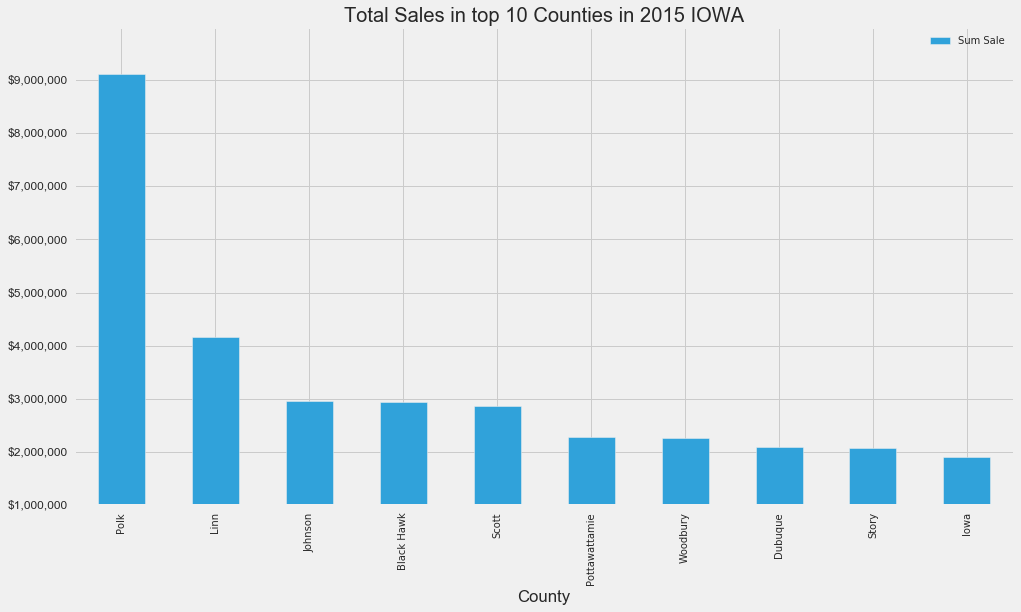

In [649]:
# Plotting total sale of each county for top 15 counties in descending sale

ax = county_15_new.head(10).plot(x = 'County', kind = "bar", y = 'Sum Sale', figsize = (15,8))

ax.set_title('Total Sales in top 10 Counties in 2015 IOWA')
ax.set_xlabel('County')
ax.set_yticklabels(['$1,000,000', '$2,000,000', '$3,000,000',\
                    '$4,000,000', '$5,000,000', '$6,000,000', \
                    '$7,000,000', '$8,000,000', '$9,000,000'], fontsize = 12);

#### Comments:

In 2015, Polk had, by far, the highest sales in all counties in IOWA, over 2 times the next highest county, Linn.

In [653]:
# Pivoting based on store number

st = pd.pivot_table(df_15, index = ['Store Number', 'County'],\
                       values = ['Bottles Sold',\
                                 'Sale (Dollars)',\
                                 'State Bottle Retail' \
                                ],\
                       aggfunc = [np.sum, np.mean]\
                      ).sort_values([('sum', 'Sale (Dollars)')], ascending = False)

st.reset_index(inplace=True)

st.head()                 

Store Number   County          sum                                     \
                        Bottles Sold Sale (Dollars) State Bottle Retail   
0         2633     Polk        62923     1000783.30            36442.23   
1         4829     Polk        52681      878812.70            34178.50   
2         3385     Linn        27363      441983.55             8921.30   
3         2512  Johnson        27692      419746.83            22567.81   
4         3420     Polk        20868      352020.66             6448.06   

          mean                                     
  Bottles Sold Sale (Dollars) State Bottle Retail  
0    31.461500     500.391650           18.221115  
1    28.693355     478.656155           18.615741  
2    57.244770     924.651778           18.663808  
3    20.125000     305.048568           16.401025  
4    61.376471    1035.354882           18.964882

In [654]:
# Extracting relevant columns into a new df

st_n = pd.concat([st['Store Number'], \
               st['County'], \
               st[('sum', 'Sale (Dollars)')], \
               st[('sum', 'Bottles Sold')], \
               st[('mean', 'State Bottle Retail')], \
               ], \
              axis = 1)

st_n.columns = ['Store Number', 'County','Sum Sale', 'Sum Bottles Sold', "Avg Bottle Price"]

st_n['Avg Bottle Price'] = st_n['Avg Bottle Price'].apply(lambda x: round(x, 2))

st_n.sort_values(['Sum Sale'], ascending = False, inplace=True)

st_n.head(10)

,Store Number,County,Sum Sale,Sum Bottles Sold,Avg Bottle Price
0,2633,Polk,1000783.30,62923,18.22
1,4829,Polk,878812.70,52681,18.62
2,3385,Linn,441983.55,27363,18.66
3,2512,Johnson,419746.83,27692,16.40
4,3420,Polk,352020.66,20868,18.96
5,3952,Iowa,333311.98,19426,19.75
6,3814,Polk,247417.42,10472,26.32
7,3354,Scott,240365.94,13737,18.71
8,3773,Linn,232460.41,13183,20.87
9,2670,Johnson,227442.71,15072,16.04


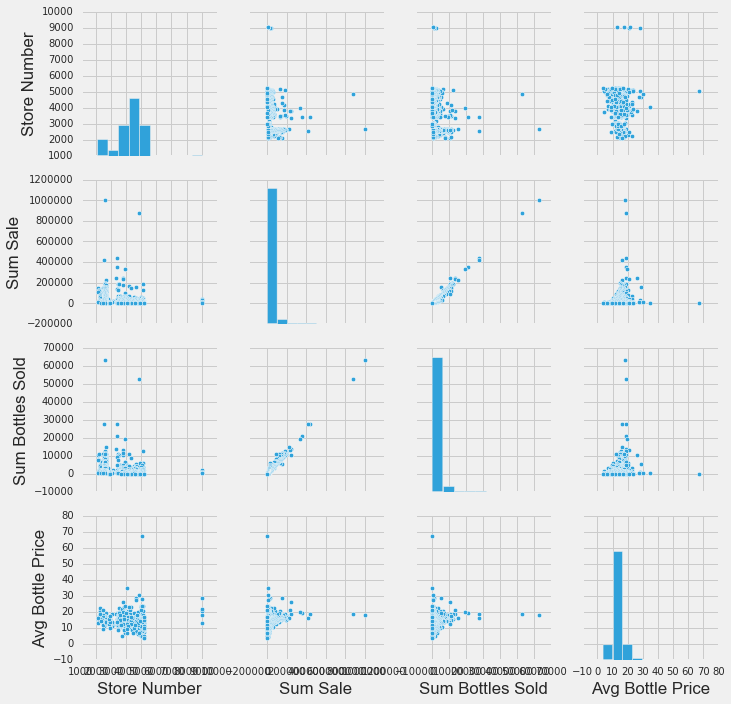

In [670]:
import seaborn as sns
sns.pairplot(st_n)

(0, 200000)

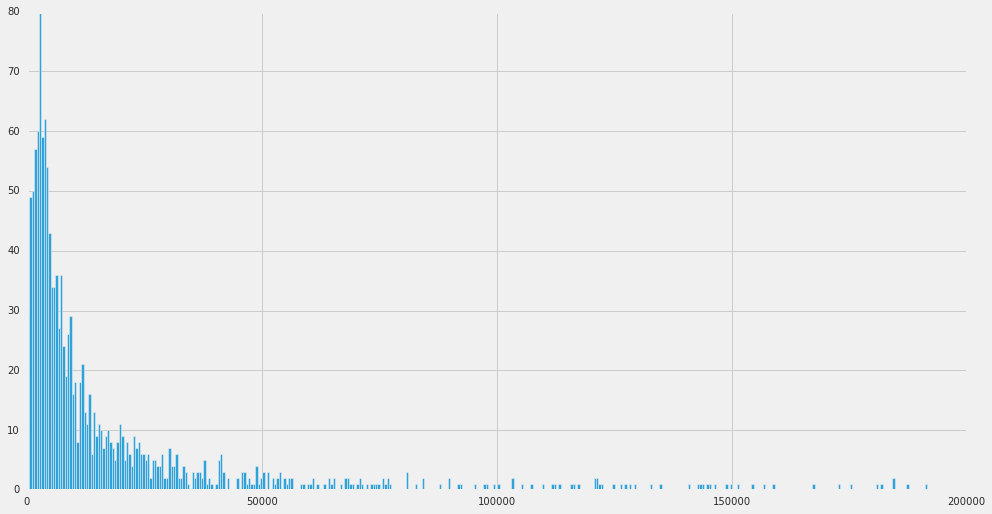

In [669]:
# Zooming into the highly skewed distribution of sale

ax = st_n['Sum Sale'].hist(bins = 2000, figsize = (15,8))
ax.set_xlim([0,200000]);

(0, 40000)

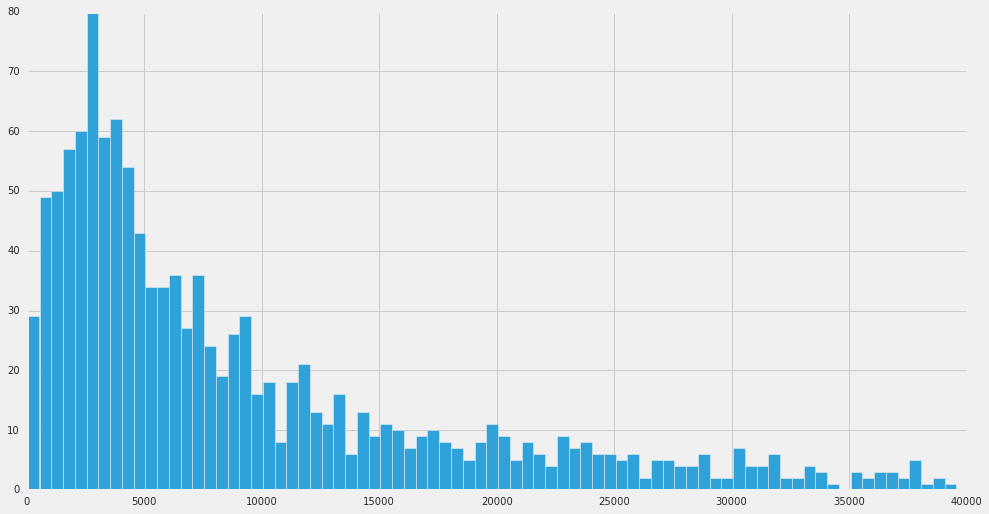

In [668]:
ax = st_n['Sum Sale'].hist(bins = 2000, figsize = (15,8))
ax.set_xlim([0,40000]);

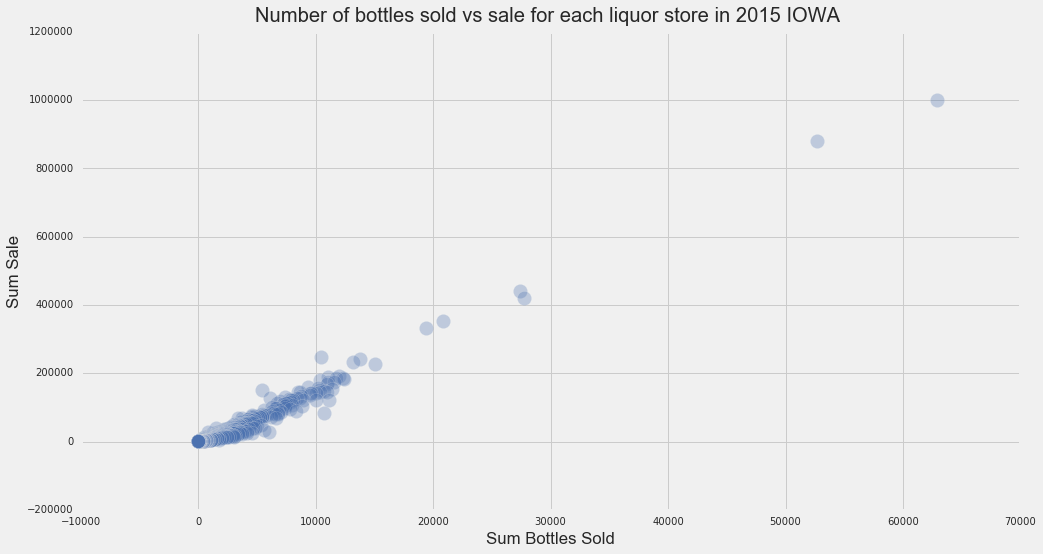

In [656]:
# Plotting number of bottles sold vs sale for each store in IOWA in 2015

ax = st_n.plot(kind = 'scatter', x = 'Sum Bottles Sold', y = 'Sum Sale',\
                  s = 200, alpha = 0.3, figsize = (15,8))
ax.set_title('Number of bottles sold vs sale for each liquor store in 2015 IOWA ', y = 1.01);

In [658]:
# View of outliers

st_n[st_n['Sum Bottles Sold'] >= 12000]

,Store Number,County,Sum Sale,Sum Bottles Sold,Avg Bottle Price
0,2633,Polk,1000783.30,62923,18.22
1,4829,Polk,878812.70,52681,18.62
2,3385,Linn,441983.55,27363,18.66
3,2512,Johnson,419746.83,27692,16.40
4,3420,Polk,352020.66,20868,18.96
5,3952,Iowa,333311.98,19426,19.75
7,3354,Scott,240365.94,13737,18.71
8,3773,Linn,232460.41,13183,20.87
9,2670,Johnson,227442.71,15072,16.04
12,5102,Linn,184582.16,12336,18.79


#### Comments:

As suspected, all these outliers came from the Top 15 counties for sale. In particular, Polk had 2 of the extreme outliers with sale of over $800,000.

## Using Median instead of mean due to presence of strong outliers

In [671]:
# Pivoting based on county

st_piv = pd.pivot_table(st_n, index = ['County'], \
                        aggfunc = [sum, np.median, pd.Series.nunique]\
                        ).sort_values(\
                                      [('median', 'Sum Sale')], ascending = False\
                                     )
st_piv.reset_index(inplace=True)
st_piv.head(15)

County              sum                                            \
                Avg Bottle Price Store Number Sum Bottles Sold    Sum Sale   
0         Jones            57.68        14120             7970   104166.25   
1       Kossuth           112.28        25489            12998   184201.54   
2    Winneshiek            74.15        21303             9021   119065.44   
3        Monona            39.20        12501             4328    53677.73   
4        Howard            48.39        11355             5690    84224.34   
5        Shelby            52.39        16434             6632    92522.53   
6         Lucas            28.62         7271             2832    36768.20   
7           Ida            61.23        17457             4458    62890.82   
8   Cerro Gordo           277.93        79865            44715   570061.54   
9      Buchanan           212.32        61367            18795   240233.47   
10        Scott           698.77       234549           133714  1520533.95   
11        Union            81.98        24852             6494    91964.12   
12        Sioux           130.89        38608            10382   157514.32   
13       Marion           148.47        42750            15312   196629.32   
14      Osceola            29.84         9480             1729    24456.70   

             median                                                   nunique  \
   Avg Bottle Price Store Number Sum Bottles Sold   Sum Sale Avg Bottle Price   
0            14.315       3690.5           2164.5  29537.870              4.0   
1            16.350       3842.0           1495.0  23243.510              7.0   
2            15.240       4183.0           1705.0  23128.850              5.0   
3            14.190       3932.0           1633.0  22826.040              3.0   
4            15.410       4233.0           1492.0  22786.770              3.0   
5            13.590       4394.5           1465.5  18459.650              4.0   
6            14.310       3635.5           1416.0  18384.100              2.0   
7            15.845       4328.0           1331.0  17616.590              4.0   
8            13.540       4352.0           1248.5  17152.870             20.0   
9            14.810       4090.0           1528.0  16161.380             15.0   
10           12.715       4642.0           1705.0  15375.265             52.0   
11           13.440       4411.0           1016.5  14592.290              6.0   
12           15.210       4256.0           1045.0  13500.680              9.0   
13           14.680       3949.0            948.0  13200.970             11.0   
14           14.920       4740.0            864.5  12228.350              2.0   

                                           
   Store Number Sum Bottles Sold Sum Sale  
0             4                4      4.0  
1             7                7      7.0  
2             5                5      5.0  
3             3                3      3.0  
4             3                3      3.0  
5             4                4      4.0  
6             2                2      2.0  
7             4                4      4.0  
8            20               20     20.0  
9            15               15     15.0  
10           54               53     54.0  
11            6                6      6.0  
12            9                9      9.0  
13           11               11     11.0  
14            2                2      2.0

In [685]:
# Selecting required columns to view county performance based on median

median_county = pd.concat([st_piv['County'], \
                           st_piv[('sum', 'Sum Sale')], \
                           st_piv[('sum', 'Sum Bottles Sold')], \
                           st_piv[('median', 'Sum Sale')], \
                           st_piv[('median', 'Sum Bottles Sold')], \
                           st_piv[('median', 'Avg Bottle Price')], \
                           st_piv[('nunique', 'Store Number')], \
                          ], \
                          axis = 1)

# Renaming the columns

median_county.columns = ['County','Sum Sale', \
                         'Sum Bottles Sold', \
                         'Median Sale', \
                         "Median Bottles Sold", \
                         "Median Bottle Price", \
                         'No. of stores']

median_county.sort_values(['Median Sale'], ascending = False, inplace=True)

median_county.head(10)

,County,Sum Sale,Sum Bottles Sold,Median Sale,Median Bottles Sold,Median Bottle Price,No. of stores
0,Jones,104166.25,7970,29537.87,2164.5,14.315,4
1,Kossuth,184201.54,12998,23243.51,1495.0,16.350,7
2,Winneshiek,119065.44,9021,23128.85,1705.0,15.240,5
3,Monona,53677.73,4328,22826.04,1633.0,14.190,3
4,Howard,84224.34,5690,22786.77,1492.0,15.410,3
5,Shelby,92522.53,6632,18459.65,1465.5,13.590,4
6,Lucas,36768.20,2832,18384.10,1416.0,14.310,2
7,Ida,62890.82,4458,17616.59,1331.0,15.845,4
8,Cerro Gordo,570061.54,44715,17152.87,1248.5,13.540,20
9,Buchanan,240233.47,18795,16161.38,1528.0,14.810,15


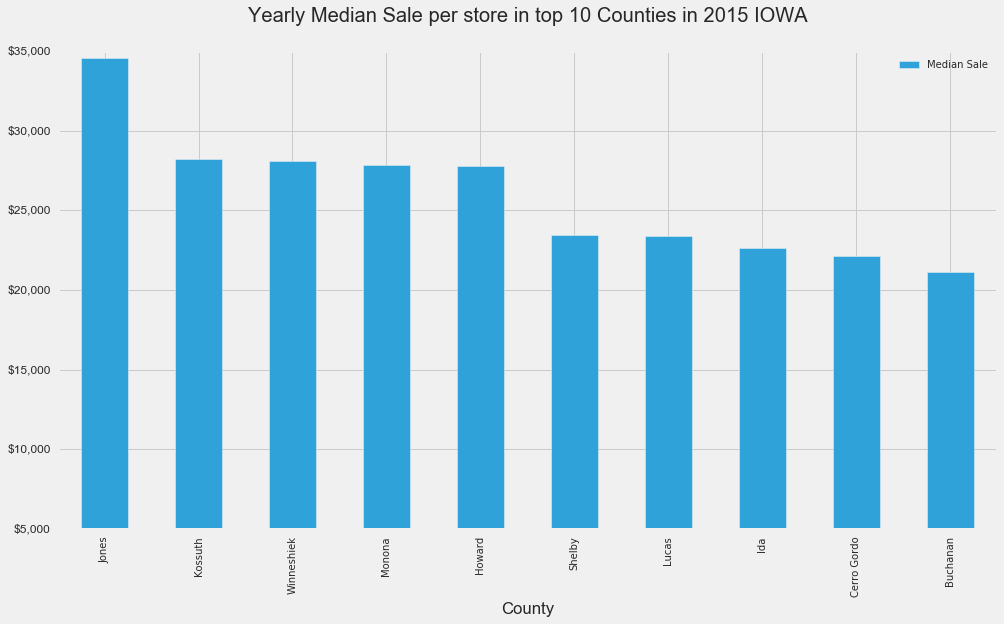

In [676]:
ax = median_county.head(10).plot(x = 'County', kind = "bar", \
                                 y = 'Median Sale', figsize = (15,8))

ax.set_title('Yearly Median Sale per store in top 10 Counties in 2015 IOWA', y = 1.05)
ax.set_xlabel('County')
ax.set_yticklabels(['$5,000', '$10,000', '$15,000',\
                    '$20,000', '$25,000', '$30,000', \
                    '$35,000', '$40,000', '$45,000'], fontsize = 12);

In [678]:
# Number of counties in IOWA

df['County'].nunique()

99

In [684]:
# Display new performance positions of previous top 3 counties

median_county[(median_county['County'] == 'Polk')|\
              (median_county['County'] == 'Linn')|\
              (median_county['County'] == 'Johnson')]

,County,Sum Sale,Sum Bottles Sold,Median Sale,Median Bottles Sold,Median Bottle Price,No. of stores
37,Johnson,1617025.98,111841,8170.855,708.5,14.435,46
46,Linn,2606326.77,202959,7390.550,727.0,12.460,101
51,Polk,6667881.06,485742,7141.575,758.0,13.560,208


#### Comments:

Due to the presence of outliers, using mean would distort the data significantly. We see that using median as a metric shows a completely different list of counties.

Interesting to note that from overwhelmingly high positions, Polk, Linn and Johnson, are not even in the top 30 counties in median yearly sale (52nd, 47th and 38th position respectively).

## Modelling

# Explore the data

Perform some exploratory statistical analysis and make some plots, such as histograms of transaction totals, bottles sold, etc.

## Record your findings

Be sure to write out anything observations from your exploratory analysis.

# Mine the data
Now you are ready to compute the variables you will use for your regression from the data. For example, you may want to
compute total sales per store from Jan to March of 2015, mean price per bottle, etc. Refer to the readme for more ideas appropriate to your scenario.

Pandas is your friend for this task. Take a look at the operations [here](http://pandas.pydata.org/pandas-docs/stable/groupby.html) for ideas on how to make the best use of pandas and feel free to search for blog and Stack Overflow posts to help you group data by certain variables and compute sums, means, etc. You may find it useful to create a new data frame to house this summary data.

# Refine the data
Look for any statistical relationships, correlations, or other relevant properties of the dataset.

# Build your models

Using scikit-learn or statsmodels, build the necessary models for your scenario. Evaluate model fit.

## Plot your results

Again make sure that you record any valuable information. For example, in the tax scenario, did you find the sales from the first three months of the year to be a good predictor of the total sales for the year? Plot the predictions versus the true values and discuss the successes and limitations of your models

# Present the Results

Present your conclusions and results. If you have more than one interesting model feel free to include more than one along with a discussion. Use your work in this notebook to prepare your write-up.